# Introduction to `geopandas`
---

Today we are going to learn how to use python and Jupyter notebooks to learn the basics of working with geospatial data in `geopandas`. `geopandas` is built on top of the `pandas` package you saw in the previous lab. Many of the methods you will see in this lab are shared between the two packages.

In [1]:
# This line tells iPython to not display warnings.
import warnings
warnings.filterwarnings('ignore')

# RUN THIS CELL FIRST or the notebook won't work
import numpy as np
import pandas as pd
import geopandas as gpd
from IPython.display import display
import matplotlib.pyplot as plt

# These help the maps display nicely in the notebook
%matplotlib inline
plt.rcParams['figure.figsize'] = [30, 20]

First, let's load our data and see what kind of data we are working with.  The `read_file` method requires that we pass the _filepath_ from our current directory (the location of this notebook) to the data. The `pwd()` function shows you the your current location in the file system. Another way you can say this is that it __p__rints your __w__orking __d__irectory.

In [2]:
pwd()

'/accounts/gen/guest/hmoore/git/cp101.github.io/labs/lab10'

To get to the data, we would first enter the `lct_000b21a_e` folder from the working directory. The way we communicate this to the function is by passing `'lct_000b21a_e/lct_000b21a_e.shp'` as an argument. This folder contains geographic information organized by census tract for the entirety of Canada.

In [3]:
canada_shp = gpd.read_file('lct_000b21a_e/lct_000b21a_e.shp')

ERROR 1: PROJ: proj_create_from_database: Open of /pool0/system/linux/mambaforge-3.11/share/proj failed


Let's take a look at what our data looks like in Jupyter. We can use the `.head()` method to show the first 5 rows of our data. Similarly, you can use the `.tail()` method to show the last 5 rows of the data.

In [4]:
canada_shp.head()

,CTUID,DGUID,CTNAME,LANDAREA,PRUID,geometry
0,5370001.08,2021S05075370001.08,0001.08,1.6383,35,"POLYGON ((7196507.366 869787.991, 7196501.617 ..."
1,0010002.00,2021S05070010002.00,0002.00,1.9638,10,"POLYGON ((8980216.643 2151065.360, 8980377.609..."
2,5370001.09,2021S05075370001.09,0001.09,1.9699,35,"POLYGON ((7196437.003 869160.246, 7196434.403 ..."
3,5370120.02,2021S05075370120.02,0120.02,76.9650,35,"POLYGON ((7189475.703 865662.849, 7189448.943 ..."
4,0010006.00,2021S05070010006.00,0006.00,1.0467,10,"POLYGON ((8980091.143 2152478.609, 8980100.254..."


This is nice, but we'd like to have some data to go with these polygons, and we'd like to just work within the Census Metropolitan Area of Toronto. Let's load some data from an earlier lab.

In [5]:
toronto_cma = pd.read_csv("~/git/cp101.github.io/labs/lab10/census21_data.csv")

In [6]:
toronto_cma.columns

Index(['Unnamed: 0', 'GeoUID', 'Type', 'Region Name', 'Area (sq km)',
       'Population', 'Dwellings', 'Households', 'CMA_UID', 'PR_UID', 'CSD_UID',
       'CD_UID',
       'v_CA21_1040: Prevalence of low income based on the Low-income measure, after tax (LIM-AT) (%)',
       'v_CA21_1043: 0 to 17 years', 'v_CA21_1046: 0 to 5 years',
       'v_CA21_1049: 18 to 64 years', 'v_CA21_1052: 65 years and over',
       'v_CA21_1085: Prevalence of low income based on the Low-income cut-offs, after tax (LICO-AT) (%)',
       'v_CA21_1088: 0 to 17 years', 'v_CA21_1091: 0 to 5 years',
       'v_CA21_1094: 18 to 64 years', 'v_CA21_1097: 65 years and over',
       'v_CA21_1140: Gini index on adjusted household total income',
       'v_CA21_1141: Gini index on adjusted household market income',
       'v_CA21_1142: Gini index on adjusted household after-tax income',
       'v_CA21_8: Total - Age', 'v_CA21_251: 65 years and over',
       'v_CA21_386: Average age', 'v_CA21_389: Average age'],
      dt

## Important

Many times over the course of reading and writing data from external sources, you might find that data types become corrupted. We can see that the GeoUID field in this dataframe ought to be right padded with zeroes so that it can match the expected form of the census tract ID in the geometry shapefile. Let's take care of that right away.

In [7]:
# fix missingness and data types
toronto_cma = toronto_cma.fillna(0)
toronto_cma = toronto_cma.replace({'NA': 0})
toronto_cma = toronto_cma.replace({'': 0})
toronto_cma.iloc[:,4:] = toronto_cma.iloc[:,4:].apply(pd.to_numeric)
# pad to get correct geouid length
toronto_cma["GeoUID"] = toronto_cma["GeoUID"].astype(str).str.ljust(10, "0")

In [8]:
toronto_cma.head()

,Unnamed: 0,GeoUID,Type,Region Name,Area (sq km),Population,Dwellings,Households,CMA_UID,PR_UID,...,v_CA21_1091: 0 to 5 years,v_CA21_1094: 18 to 64 years,v_CA21_1097: 65 years and over,v_CA21_1140: Gini index on adjusted household total income,v_CA21_1141: Gini index on adjusted household market income,v_CA21_1142: Gini index on adjusted household after-tax income,v_CA21_8: Total - Age,v_CA21_251: 65 years and over,v_CA21_386: Average age,v_CA21_389: Average age
0,1,5350001.00,CT,1.0,6.8192,599,253,235,35535,0.0,...,0.0,6.0,8.0,0.360,0.426,0.309,600.0,55.0,38.9,40.4
1,2,5350002.00,CT,2.0,3.3926,604,294,284,35535,0.0,...,0.0,11.0,7.0,0.346,0.460,0.301,605.0,250.0,55.0,62.0
2,3,5350003.00,CT,3.0,0.9455,457,279,265,35535,0.0,...,0.0,8.0,0.0,0.370,0.446,0.322,460.0,45.0,39.6,38.0
3,4,5350004.00,CT,4.0,0.3404,6306,3620,3276,35535,0.0,...,8.0,16.2,10.8,0.358,0.544,0.314,6310.0,840.0,41.8,40.0
4,5,5350005.00,CT,5.0,0.3764,6957,4235,3720,35535,0.0,...,7.0,13.0,14.2,0.380,0.513,0.334,6950.0,865.0,39.9,36.4


Much better. Now, let's do a left inner join to the GeoPandas dataframes so that the resulting object will retain its geometric properties.

In [25]:
toronto_gpd = canada_shp.merge(toronto_cma, how = "inner", left_on = "CTUID", right_on = "GeoUID")
toronto_gpd.head()

,CTUID,DGUID,CTNAME,LANDAREA,PRUID,geometry,Unnamed: 0,GeoUID,Type,Region Name,...,v_CA21_1091: 0 to 5 years,v_CA21_1094: 18 to 64 years,v_CA21_1097: 65 years and over,v_CA21_1140: Gini index on adjusted household total income,v_CA21_1141: Gini index on adjusted household market income,v_CA21_1142: Gini index on adjusted household after-tax income,v_CA21_8: Total - Age,v_CA21_251: 65 years and over,v_CA21_386: Average age,v_CA21_389: Average age
0,5350420.13,2021S05075350420.13,0420.13,1.8675,35,"POLYGON ((7218613.794 949619.114, 7218679.703 ...",706,5350420.13,CT,420.13,...,6.0,8.4,13.0,0.360,0.462,0.316,6205.0,985.0,41.9,41.2
1,5350422.03,2021S05075350422.03,0422.03,3.5903,35,"POLYGON ((7219855.811 954804.291, 7219916.443 ...",715,5350422.03,CT,422.03,...,6.0,5.4,5.0,0.323,0.414,0.283,6810.0,825.0,39.6,42.0
2,5350422.04,2021S05075350422.04,0422.04,0.8388,35,"POLYGON ((7217958.140 954705.514, 7217957.497 ...",716,5350422.04,CT,422.04,...,8.0,6.5,5.2,0.350,0.441,0.313,3760.0,545.0,41.4,45.2
3,5350422.05,2021S05075350422.05,0422.05,1.5519,35,"POLYGON ((7216908.840 954698.554, 7216912.983 ...",717,5350422.05,CT,422.05,...,12.0,7.4,4.4,0.344,0.433,0.302,6730.0,895.0,41.2,45.6
4,5350422.06,2021S05075350422.06,0422.06,1.8382,35,"POLYGON ((7215728.211 952217.103, 7215620.917 ...",718,5350422.06,CT,422.06,...,13.0,11.8,8.0,0.363,0.545,0.320,5355.0,1280.0,45.0,46.0


## Examining the data 

### Accessing the data <font color='red'> 

The `.loc[]` and `.iloc[]` methods allow us to view cells in a `DataFrame` or `GeoDataFrame` based on their name or location. The __i__ in `.iloc[]` stands for the __integer__ position of a cell, and accesses cells by location in index coordinates. The `.loc[]` method allows you to access cells by the index of the rows and the names of the columns. For both `.loc[]` and `.iloc[]`, the first argument refers to the row, and the second argument refers to the column.

Typically the row index will be the same as its integer position, but that is not always the case. Let's set up a `DataFrame` to see this in action.

In [26]:
df = pd.DataFrame(data = {'a': [1, 2, 3],
                         'b': [4, 5, 6],
                         'c': [7, 8, 9],
                         'd': [10, 11, 12]},
                 index = [1.1, 1.2, 1.3])
df

,a,b,c,d
1.1,1,4,7,10
1.2,2,5,8,11
1.3,3,6,9,12


If we want to access the number 8 from `df`, we would need to tell `.iloc[]` to look in `df` at row `1`, column `2` (remember that python starts counting from zero!).

In [27]:
df.iloc[1, 2]

8

Using `.loc[]`, we would need to tell the method that we want row index `1.2`, column name `'c'`.

In [28]:
df.loc[1.2, 'c']

8

You can also specify a range of indices to both of these methods if you want to access multiple adjacent cells. For `iloc[]`, this range will always refer to integer coordinates of the cells.

In [29]:
# This code tells .iloc that we want rows 0 and 2, then all columns with index
# greater than or equal to 1.
df.iloc[[0, 2], 1:]

,b,c,d
1.1,4,7,10
1.3,6,9,12


We can also refer to a range named columns and rows using `.loc[]`

In [30]:
# This code tells .loc that we want row 1.2, columns 'b' through 'd' inclusive.
df.loc[[1.2], 'b':'d']

,b,c,d
1.2,5,8,11


### Basic maps <font color='red'>

The `geometry` column contains a new data type called a polygon, which is how `geopandas` is able to store geographic information. Let's look at one of these polygons using `.loc[]`.

Is this a part of Toronto you recognize? Perhaps on a large park on the lakefront?

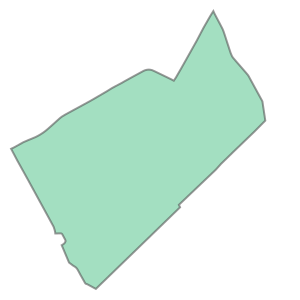

In [31]:
toronto_gpd.loc[7, 'geometry']

Or perhaps this warped rectangle? A familiar university campus, near an urban park? 

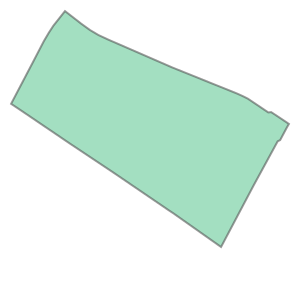

In [32]:
toronto_gpd.loc[55, 'geometry']

To view all of the polygons in the `GeoDataFrame`, we can just use the `.plot()` method. The documentation for this function can be found [here](http://geopandas.org/mapping.html).

<AxesSubplot: >

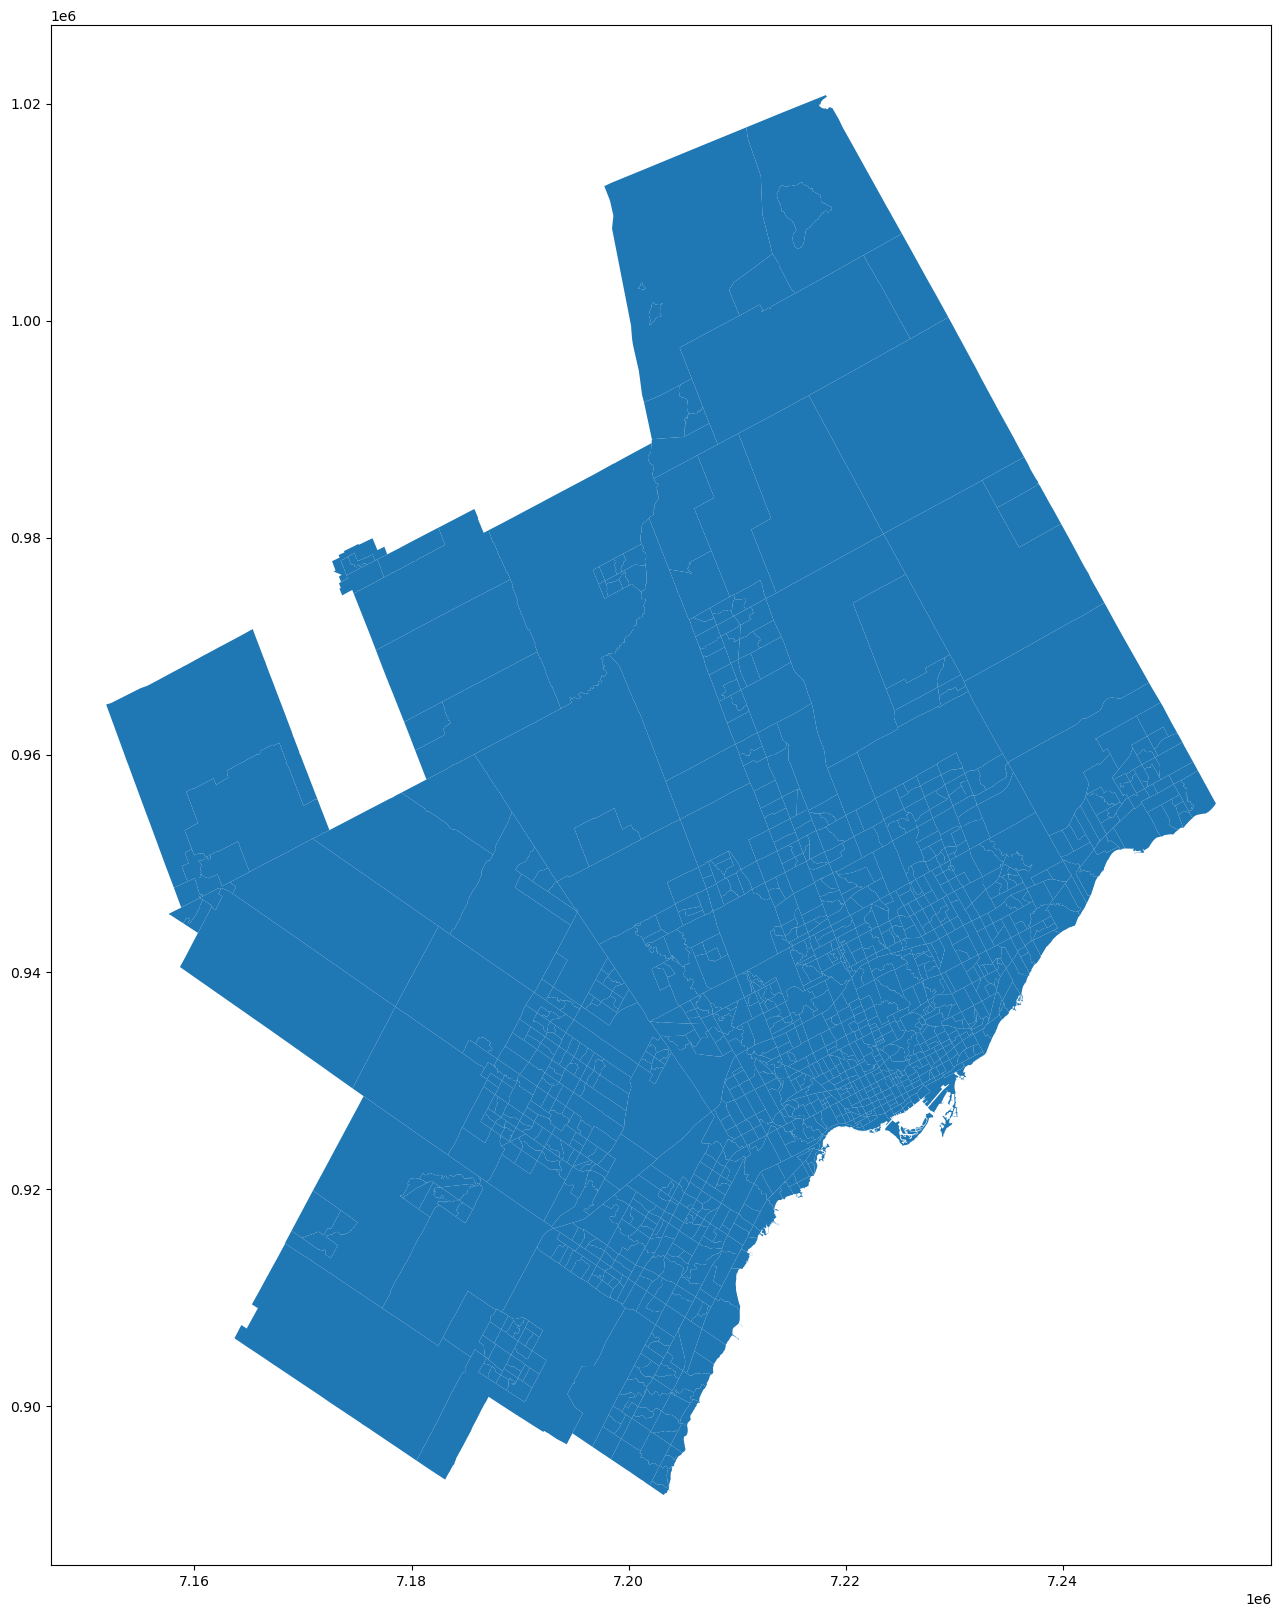

In [33]:
toronto_gpd.plot()

You can improve the appearance of this graph by removing the axis labels surrounding the map and adding a title. You may also see a line that says something like `<matplotlib.axes._subplots.AxesSubplot at [hexadecimal]>` above the map. You can prevent Jupyter from displaying this line by adding a `;` to the last line of code creating the map.

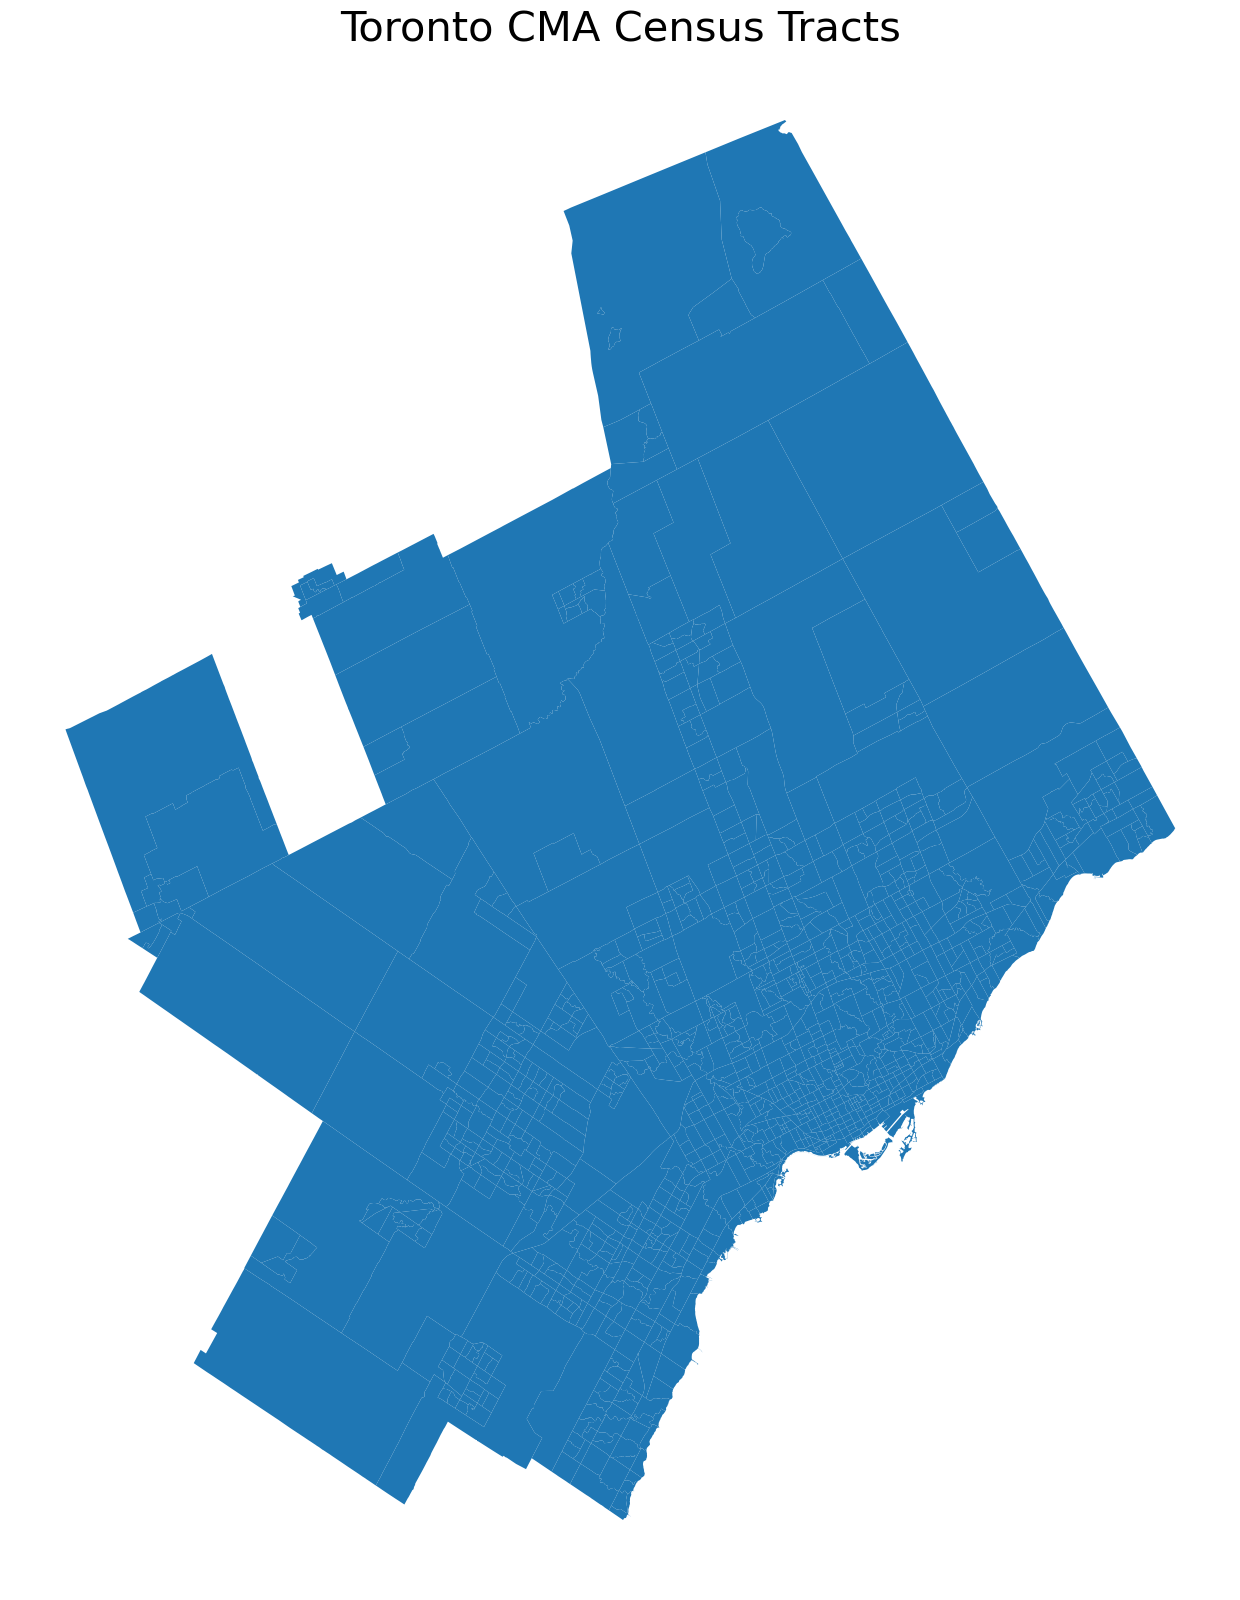

In [34]:
toronto_gpd.plot()

# Adding the fontsize argument allows you to manipulate the font size.
plt.title('Toronto CMA Census Tracts', fontsize = 30)

# This turns the plot axes off.
plt.axis('off');

# Creating a new shapefile
    
These are nice maps, but there are ways to make it more informative. For starters, the Toronto CMA is quite a large area with a high amount of variance in census tract area. This does not make for the most visually pleasing map, so for now let's continue on a previous theme and focus just on the City of Toronto. 
    
We can do this by performing an inner join on the GeoUIDs of census tracts we queried in previous labs. 

In [41]:
toronto_csd = pd.read_csv('~/git/cp101.github.io/labs/lab03/census21_data.csv')
# fix missingness and data types
toronto_csd = toronto_csd.fillna(0)
toronto_csd = toronto_csd.replace({'NA': 0})
toronto_csd = toronto_csd.replace({'': 0})
# pad to get correct geouid length
toronto_csd["GeoUID"] = toronto_csd["GeoUID"].astype(str).str.ljust(10, "0")

The data in our `GeoDataFrame` are all strings, so we need to convert these numbers into strings before python can compare them to our data. We are going to use a technique called a list comprehension to do this. A list comprehension is basically a for loop condensed into a single line.

In [ ]:
berkeley_census_tracts = [str(id) for id in berkeley_census_tracts]

If we were going to write this list comprehension as a for loop, we would have to create a new list to save our converted data into. It would look a little something like this:
```
berkeley_census_tracts_str = []
for id in berkley_census_tracts:
    berkeley_census_tracts_str.append(str(id))
```
List comprehensions are so much more efficient!

Next, we are going to use a for loop to look at all of the rows in `alameda` and add the rows belonging to Berkeley census tracts to a new `GeoDataFrame`.

In [ ]:
# Create a new GeoDataFrame
berkeley = gpd.GeoDataFrame()
for row in range(len(alameda)):
    # If the NAME of a census tract is in our list of Berkeley census tracts, we want to
    # add it to our berkeley GeoDataFrame.
    if alameda.loc[row, 'NAME'] in berkeley_census_tracts:
        berkeley = berkeley.append(alameda.loc[row, :])
berkeley.head()

Next, we can save our new `GeoDataFrame`. The following code saves `berkeley` as a file type called a "shapefile," which happens to be the same file type as the data we read in earlier. `geopandas` can also read and write many other geospatial file types, but we are just going to be using the same file type as before for now.

In [ ]:
berkeley.to_file(driver='ESRI Shapefile', filename = 'shapefiles/berkeley')

Now we can make a map with our new data.

In [ ]:
berkeley.plot(column = 'medianage', legend = True)
bounds = berkeley.bounds.iloc[0]
minx = bounds["minx"]
miny = bounds["miny"]
plt.text(minx + 0.0625, miny - 0.015, 'Median Age in Years', fontsize=20, rotation=90, rotation_mode='anchor')
plt.title('Berkeley Median Age by Census Tract', fontsize = 30)
plt.axis('off');

Can you tell which census tracts are likely to be near the University of Toronto campus, just from looking at this map? If yes, why might that be? If no, what other information would you need in order to do so?

YOUR ANSWER HERE

If we want to make this map more informative, we can incorporate some of the other columns from the data into the map. For example, the `v_CA21_1142` vector contains [Gini index](https://www.physics.ucla.edu/~chester/GINI/index.html) of each census tract.

In [36]:
toronto_gpd['v_CA21_1142: Gini index on adjusted household after-tax income']

0       0.316
1       0.283
2       0.313
3       0.302
4       0.320
        ...  
1222    0.232
1223    0.322
1224    0.354
1225    0.247
1226    0.257
Name: v_CA21_1142: Gini index on adjusted household after-tax income, Length: 1227, dtype: float64

In [37]:
min(toronto_gpd.bounds['minx'])

7151866.545714326

We can pass the column name as an optional argument to the `.plot()` method to create a map with a color gradient based on the values in this column. Setting `legend` equal to `True` in the function call will also tell the method that we want our final plot to have a legend so that we can interpret the colors on the map. 

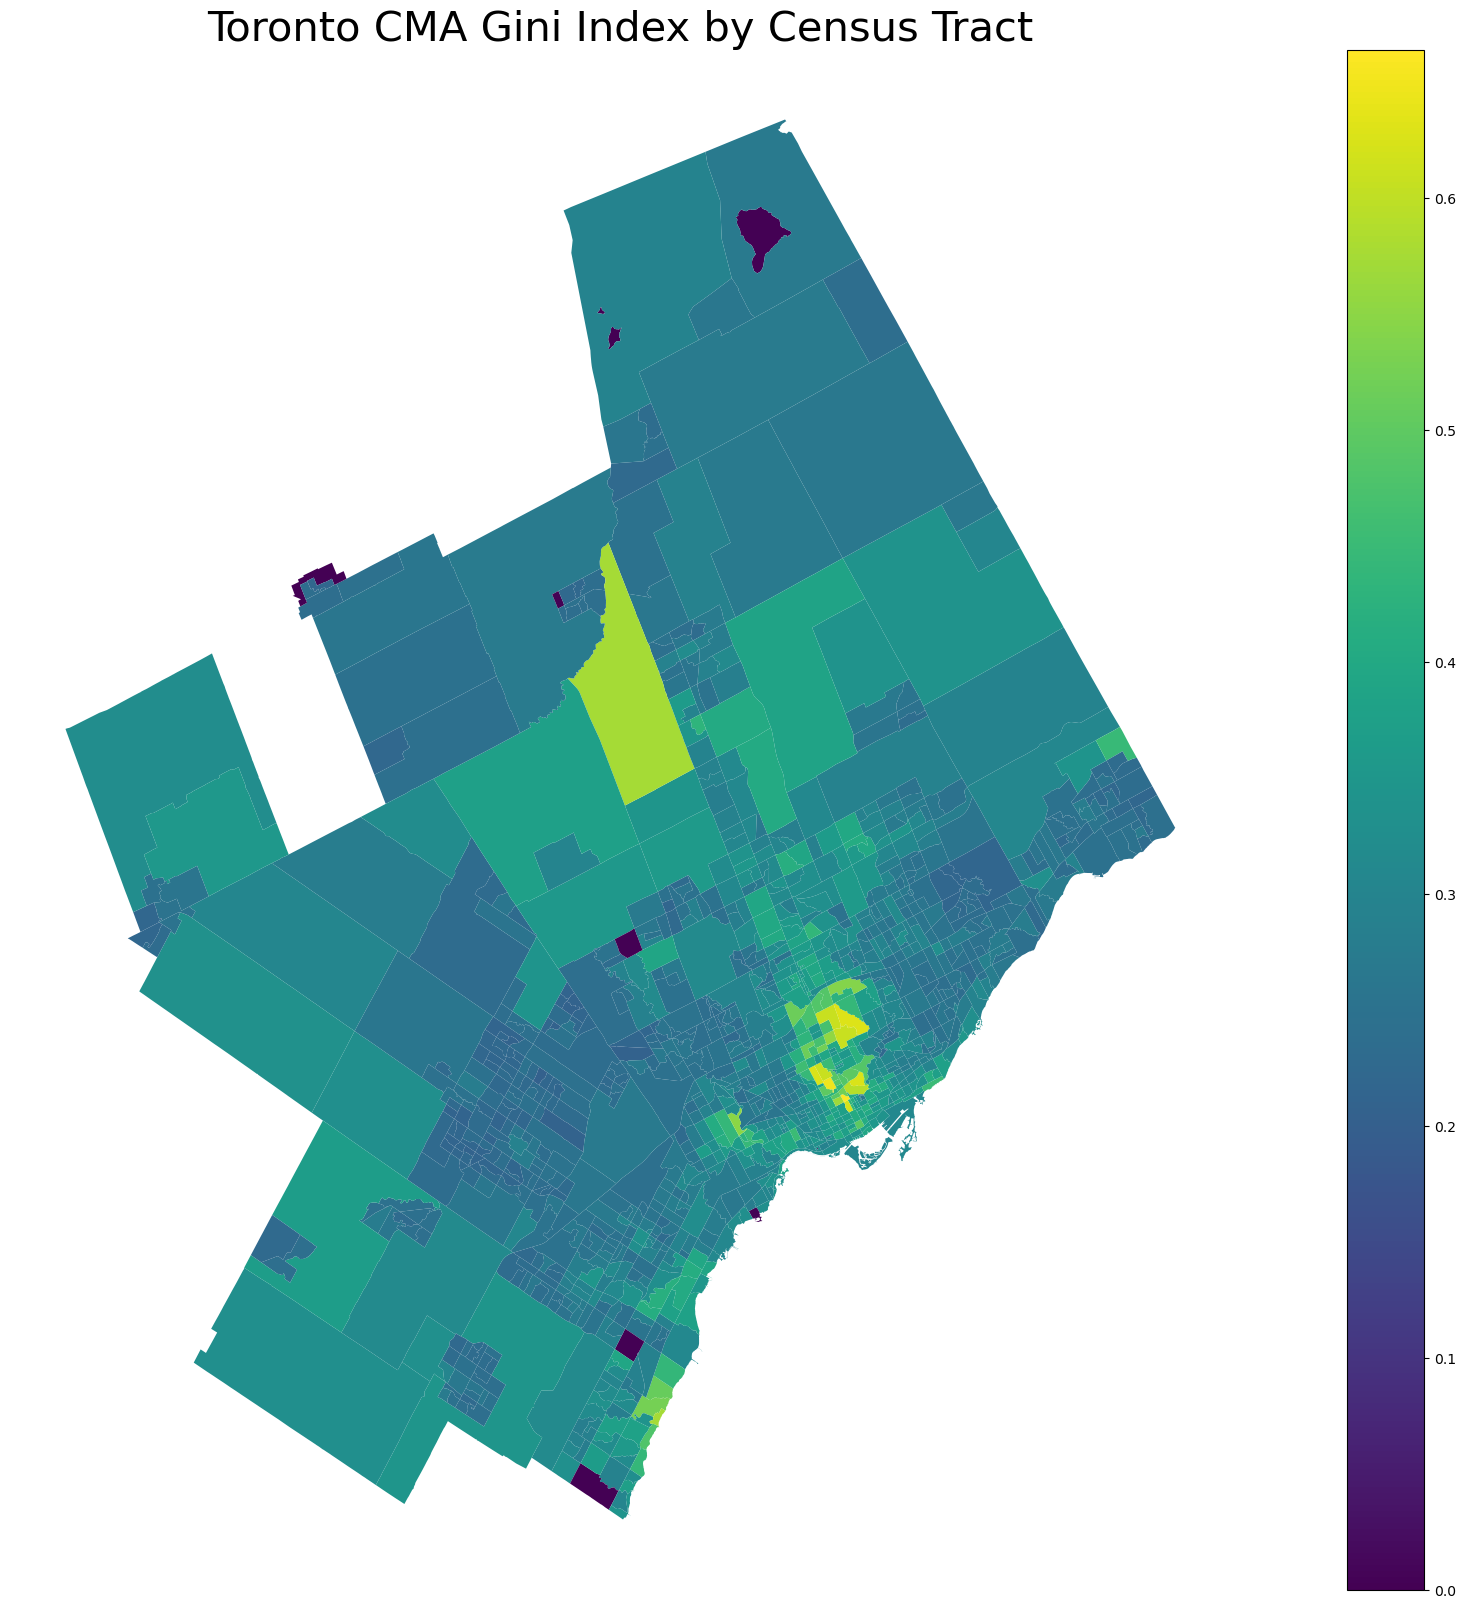

In [38]:
toronto_gpd.plot(column = 'v_CA21_1142: Gini index on adjusted household after-tax income', legend = True)
#Bounds supplies information on the maximum and minimum values of the x-axis and y-axis of our plot.
#bounds = toronto_gpd.bounds
#minx = max(bounds["minx"])
#miny = min(bounds["miny"])
# We use that information to place the text label for our legend
#plt.text(minx + 11000, miny - 0.3, 'Gini Index on adjusted household after-tax income', fontsize=20, rotation=90, rotation_mode='anchor')
plt.title('Toronto CMA Gini Index by Census Tract', fontsize = 30)
plt.axis('off');

If you want to change the color scheme of the map, you can choose the "color map" of the plot by adding in the optional `cmap` argument to `plot()`. You can choose from the variety of color maps available in the `matplotlib` package, which is what our plotting software is built off of. Above, we saw the default colormap, which is called viridis. If you want to view all the available colormaps, you can reference the documentation [here](https://matplotlib.org/users/colormaps.html).

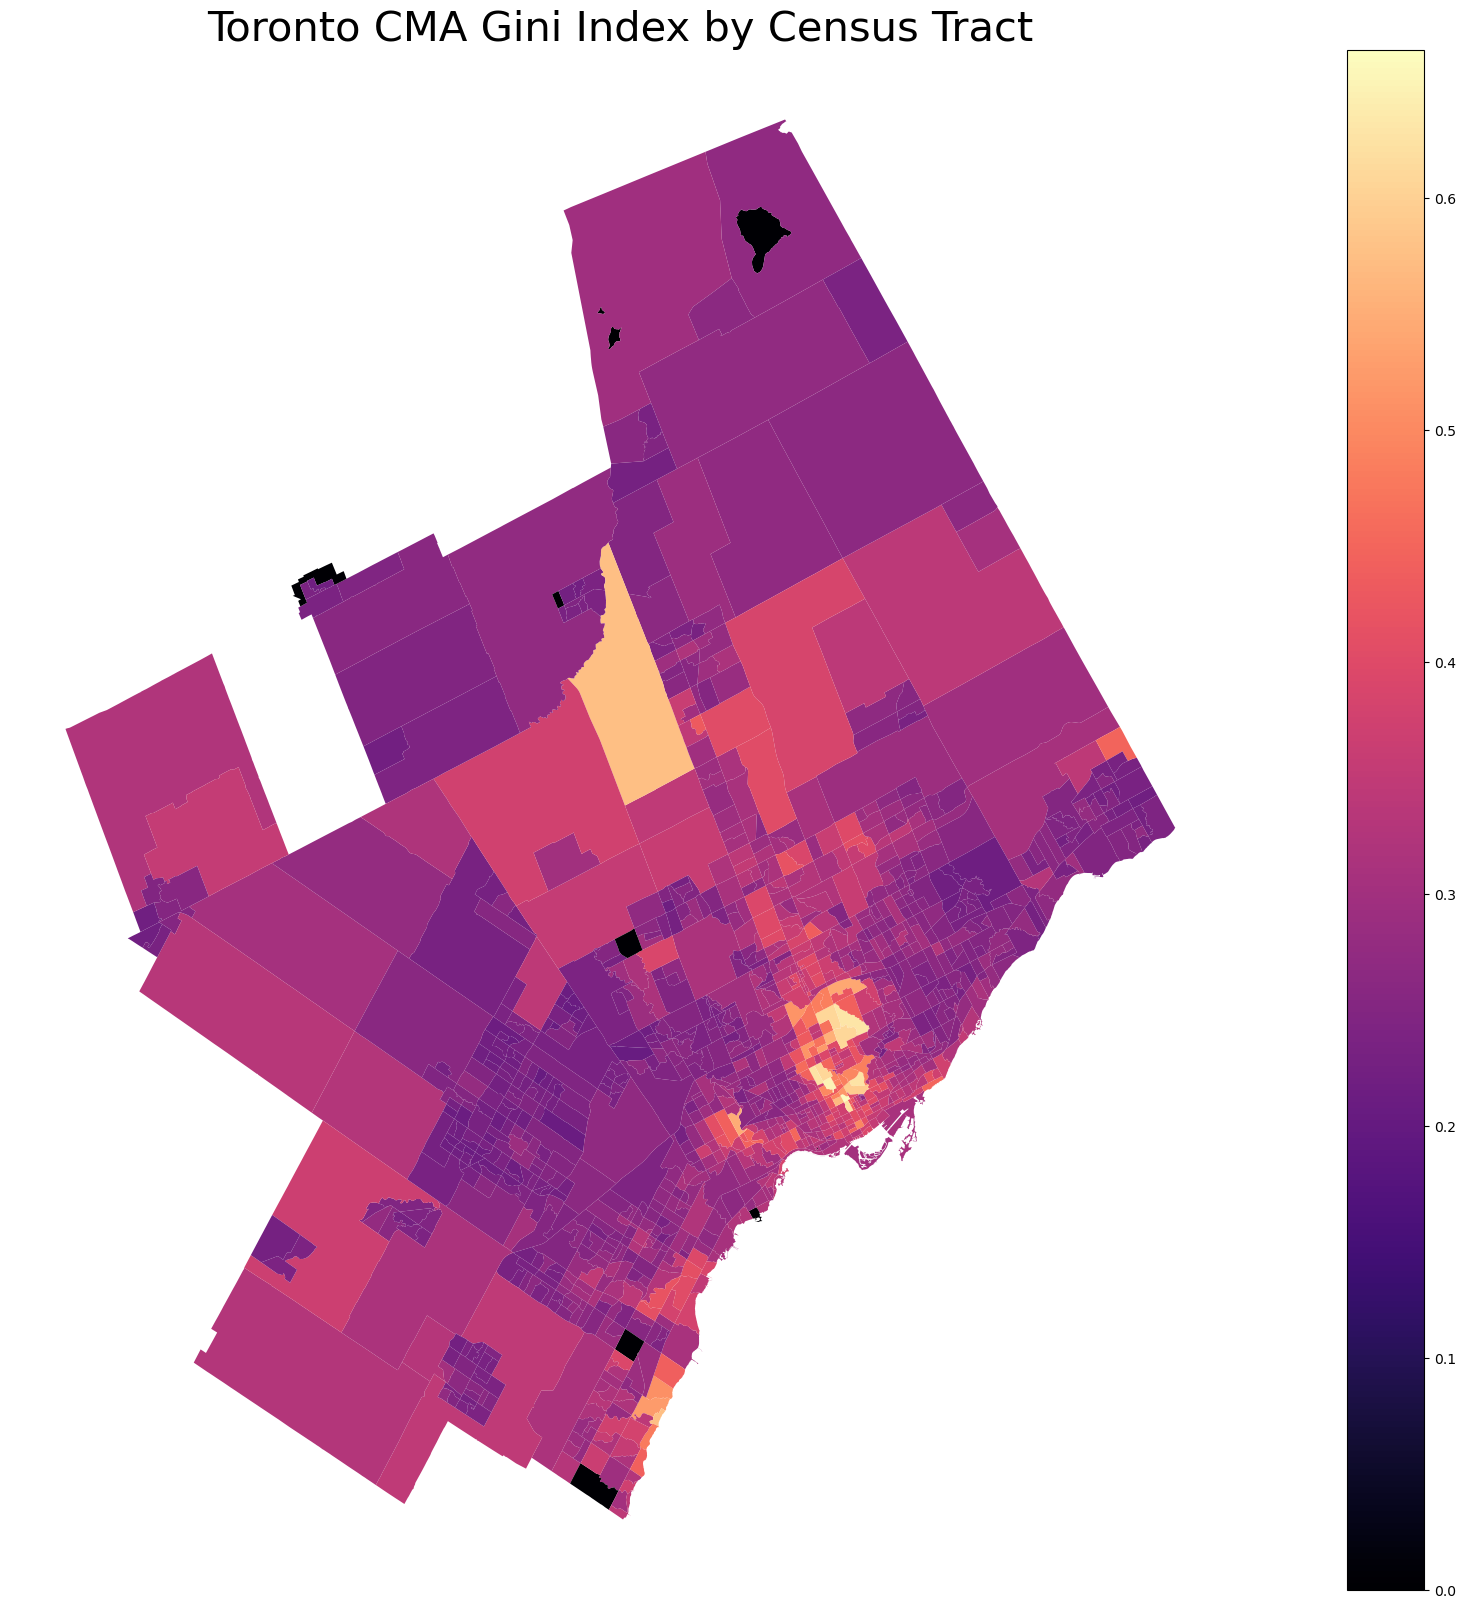

In [39]:
toronto_gpd.plot(column = 'v_CA21_1142: Gini index on adjusted household after-tax income', legend = True, cmap = 'magma')
#bounds = toronto_gpd.bounds
#minx = max(bounds["minx"])
#miny = min(bounds["miny"])
# We use that information to place the text label for our legend
#plt.text(minx + 11000, miny - 0.3, 'Gini Index on adjusted household after-tax income', fontsize=20, rotation=90, rotation_mode='anchor')
plt.title('Toronto CMA Gini Index by Census Tract', fontsize = 30)
plt.axis('off');

Now it's your turn! In the following cell, try creating your own choropleth map using a different column from `toronto_gpd`. If you want to see all of the columns in our data, you can scroll up to where we displayed all of the column names.

<font color = 'red'>

In [ ]:
# YOUR CODE HERE
toronto_gpd.plot(column = 'v_CA21_1142: Gini index on adjusted household after-tax income', legend = True, cmap = 'Wistia')
#bounds = toronto_gpd.bounds
#minx = max(bounds["minx"])
#miny = min(bounds["miny"])
# We use that information to place the text label for our legend
#plt.text(minx + 11000, miny - 0.3, 'Gini Index on adjusted household after-tax income', fontsize=20, rotation=90, rotation_mode='anchor')
plt.title('Toronto CMA Gini Index by Census Tract', fontsize = 30)
plt.axis('off');

What are some conclusions that you can draw from the map you created?

YOUR ANSWER HERE

## Coordinate Reference Systems (CRS)

Statistics Canada uses a special Coordinate Reference System called [Statistics Canada Lambert](https://epsg.io/3347) (EPSG:3347) for its shapefiles. You can read Statistics Canada's Illustrated Glossary page, including why this projection is used for most statistical analysis of Canadian geographies [here](https://www150.statcan.gc.ca/n1/pub/92-195-x/2021001/other-autre/coord/coord-eng.htm). 


A standard CRS used internationally for a variety of catography and satellite navigateion is the World Geodetic System. The Map and Data Library has several Toronto-centric datasets- pay special attention to their projection before working with them. The EPSG values are shortened abbreviations of the coordinate system names that can be used to easily convert between projections using geospatial software/libraries. You can read more about EPSG [here](https://epsg.org/home.html).

In [ ]:
# WGS84's epsg abbreviation is 4326
toronto_gpd.crs = {'init': 'epsg:4326'}

In [ ]:
# there is a chance this will error- the shapefile may be too large to plot after reprojecting its coordinates
toronto_gpd.iloc[:10, :].plot()
plt.title('Toronto CMA Census Tracts', fontsize = 30)
plt.axis('off');

In [ ]:
toronto.head()

### Combining multiple `GeoDataFrames` <font color = 'red'> (53:40)

When working with multiple sets of geospatial data, we may need to plot multiple `GeoDataFrames` together on the same map. There are a few different ways we can do this.

If one of our `GeoDataFrames` covers a smaller area than the other, we can use the `GeoDataFrame` with the larger area as a base on top of which we plot the smaller `GeoDataFrame`. To do this, we use the optional `ax` argument when plotting the smaller `GeoDataFrame` to tell the plotting sofware that we want to continue using a previously plotted map.

In [ ]:
berkeley.crs ={'init': 'epsg:4326'}

In [ ]:
# We can also define explicitly the colors of the lines and open spaces on our map.
base = alameda.plot(color = 'white', edgecolor = 'black')
berkeley.plot(ax = base, color = 'blue', edgecolor = 'red')
plt.axis('off');

We may also have separate `GeoDataFrames` that do not overlap, and we may want to combine them into a single table. Let's load in some more data so we can see this in action.

First, we need to read in our data. Let's use the `read_file` method from before to load in shapefiles in the `contra_costa` and `san_francisco` folders inside the `shapefiles` folder.

In [ ]:
contra_costa = gpd.read_file('shapefiles/contra_costa')
san_francisco = gpd.read_file('shapefiles/san_francisco')

Now that you have loaded the data in, let's take a look at the columns it contains.

In [ ]:
contra_costa.columns

In [ ]:
san_francisco.columns

Since `contra_costa` and `san_francisco` both have the same columns as `alameda`, we can use the `.append()` method to combine them without introducing any missing values, or spaces in our data table that do not have any information. Different packages can often have different ways of dealing with missing values, such completely ignoring any rows containing missing values to interpreting missing values as some default value. Since we do not have any missing values here, we don't have to worry about this.

In [ ]:
# These three lines create a new column called 'county' in each of the GeoDataFrames,
# then assigns the name of the county to all rows within the GeoDataFrame.
alameda['county'] = 'alameda'
contra_costa['county'] = 'contra costa'
san_francisco['county'] = 'san francisco'

# This creates a new, empty GeoDataFrame, then appends of our GeoDataFrames to it.
data = gpd.GeoDataFrame()
data = data.append(alameda)
data = data.append(contra_costa)
data = data.append(san_francisco)

# This plots our new aggregated GeoDataFrame using the 'county' column we created
# above.
data.crs ={'init': 'epsg:4326'}
data.plot(column = 'county', legend = True, cmap = 'Set3')
plt.axis('off');

Note that the code for this map has essentially the same form as the choropleth maps we created earlier. Since the column we are using to distinguish the census transects from each other is text rather than continuous numerical values, the plotting software uses distinct colors rather than a smooth spectrum.

# More geospatial data types in `geopandas` <font color = 'red'>

So far, we have only been creating maps using polygons, but `geopandas` has a few more data types we can work with. First, we need some new data to work with. In the `shapefiles` folder, we have folders named `bart_stations` and `bart_routes` containing geospatial data about the BART system. Load in the data as we did with `alameda` file from the beginning of the lab.

In [ ]:
# https://open.toronto.ca/dataset/ttc-routes-and-schedules/
# https://open.toronto.ca/dataset/major-city-wide-cycling-routes/


bart_stations = gpd.read_file('shapefiles/bart_stations')
bart_routes = gpd.read_file('shapefiles/bart_routes')

## Examining the data

To get an idea of what the data we are working with looks like, let's call the `.head()` method on the data we have just read.

In [ ]:
bart_stations.head()

In [ ]:
bart_routes.head()

Looking at the `geometry` columns of our two GeoDataFrames, we can see that we have some new types of data. Where we had polygons before, our new data have points and linestrings. Points are are exactly what they sound like, 1-dimensional coordinates in space. Linestrings are line segments that do not necessarily have to be a straight line.

Use the following cell to draw a linestring the same way we did the first time we looked at a polygon.

In [ ]:
# YOUR CODE HERE
bart_routes.loc[0, 'geometry']

## Creating the map

In the next few cells, you will create a map that overlays the bart stations and routes over a map of all the counties. (Alameda, Contra Costa, and San Francisco)

First, we need the base map of all the counties. We can use the aggregated `GeoDataFrame` we created earlier in this notebook. Try setting the `color` and `edgecolor` arguments so the map looks more uniform.

In [ ]:
base = data.plot()
plt.axis('off');

Next, overlay the routes and stations and plot the graph by using this as the base for the map. The Jupyter notebook will not remember the map you drew in the previous cell even if you assigned it a name, so make sure to plot the base map again in the following cell.

In [ ]:
base = data.plot(color = '#d8dcd6', zorder=1)
bart_routes.plot(ax=base, color = '#789b73', linewidth = 6, zorder=2)
bart_stations.plot(ax=base, color = '#cdfd02', markersize = 150, zorder=3)
plt.axis('off');

In [ ]:
base = data.plot(color = '#d8dcd6', zorder=1)
bart_routes.plot(ax=base, color = '#789b73', linewidth = 6, zorder=2)
bart_stations.plot(ax=base, color = '#cdfd02', markersize = 150, zorder=3)
plt.xlim(-122.53, -122.10)
plt.ylim(37.71, 37.91)

plt.axis('on');

Congratulations! You're done with this lab! If you are interested in learning more about what you can do with `geopandas`, you can find the documentation for the package [here](http://geopandas.org/reference.html).

***